# **[MC906] Projeto Final**: Detecção de Desastres

O objetivo desse projeto é construir e avaliar modelos de aprendizado de máquina que classifiquem quais Tweets são sobre desastres reais e quais não são.

## **Acessar Diretório do Projeto**

Esse Notebook assume que você está executando o código dentro da pasta `Projeto Final/Código`, que contém todos os códigos fontes relativos a esse trabalho. Para acessar o diretório no Colab é preciso criar um atalho em seu Drive (right click no diretório -> "Adicionar atalho ao Google Drive") e executar as células abaixo:

In [ ]:
# Conectar ao Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Diretório do Projeto (/content/drive/My Drive/{path até Projeto Final/Código}), 
# dependendo da onde se localiza o atalho no seu Drive
% cd '/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código'
! ls

/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final
'Copy of Attention CNN'		     Glove
'Copy of authors.txt'		     __pycache__
'Copy of Quasi-Recurrent Networks'  'Recurrent Neural Networks'
'Copy of requirements.txt'	     Relatório
 Dataset			     utils.py
'Dense Neural Networks'


## **Dependências:**


In [ ]:
# Imports de pacotes instalados
import matplotlib.pyplot as plt
import numpy as np
from os.path import join, exists
import pandas as pd
from tensorflow.keras.layers import Input, Activation, Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Attention, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

# Imports locais
from utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Dataset:**

Utilizamos um *dataset* disponível no site [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (em inglês). Cada tweet apresenta três atributos: seu conteúdo (`text`), uma palavra-chave (`keyword`, opcional) e a localização da onde foi enviado (`location`, opcional). Como só usaremos o texto, removemos os dois últimos.

In [ ]:
# Ler e limpar dados (removendo colunas do id, keyword e location)
train = pd.read_csv("../Dataset/train.csv", dtype={'id': np.int16, 'target': np.int8})
train = train.drop(['id','keyword','location'], axis=1)

# Imprimir alguns dados
print(train.head())
vals = train.groupby('target').count()
print("\nSome General insights:")
print(f"Figure of Speech: {vals.iloc[0]['text']*100/len(train):.2f}%")
print(f"Actual Accidents: {vals.iloc[1]['text']*100/len(train):.2f}%")

# Salvar targets
Y = np.array([[x] for x in train.target.tolist()])

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Some General insights:
Figure of Speech: 57.03%
Actual Accidents: 42.97%


## **Pré-Processamento:**

*Global Vectors for Word Representation*, ou GloVe, é um algoritmo de aprendizado não-supervisionado com o objetivo de obter representações vetoriais para palavras, proposto em 2014. O algoritmo mapeia as palavras no espaço, tal que a distância e a semelhança semântica entre elas é proporcional.

Utilizamos sua representação de palavras para nosso conjunto de dados e seus pesos pré-treinados na camada de Embedding da rede, mais especificamente o arquivo *glove.840B.300d.txt*.

In [ ]:
# Aplicar tokenização
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(train['text'])
sequences = tokenizer.texts_to_sequences(train['text'])
X = pad_sequences(sequences, maxlen=50)

In [ ]:
# Preparar incorporação de palavras
embeddings_index = dict()
f = open('../Glove/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
        float(values[1])
    except ValueError:
        continue
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# Construir matriz de incorporação
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

## **Modelo**: Redes Convolucionais com Atenção

Um método alternativo testado foi o de redes convolucionais com mecanismo de atenção para modelar dependências. Empregamos um modelo de auto-atenção *self-attention* no qual os campos de *query* e *value* são iguais.

Abaixo, implementamos uma rede convolucional simples usando as camadas *Conv1D*, com 128 filtros, *GlobalMaxPooling1D* e *Attention* da biblioteca *Tensorflow (Keras)*.

In [ ]:
def att_CNN(max_words=20000, max_len=X.shape[1]):
  ''' Função que constrói o modelo CNN com atenção. '''

  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 300, input_length=max_len, weights=[embedding_matrix],trainable=False)(inputs)
  layer = Conv1D(128, 5)(layer)
  layer = Activation('relu')(layer)
  self_att = Attention()([layer,layer])
  layer_pool = GlobalMaxPooling1D()(layer)
  self_pool = GlobalMaxPooling1D()(self_att)
  conc = concatenate([layer_pool, self_pool])
  layer = Dense(1)(conc)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
# Construir e compilar modelo
att_cnn = att_CNN()
att_cnn.summary()
att_cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      6000000     inputs[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 46, 128)      192128      embedding_1[0][0]                
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 46, 128)      0           conv1d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_attention.h5', save_best_only=True)]
att_history = att_cnn.fit(X,Y,batch_size=100,epochs=10, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_attention.h5'):
    att_cnn = load_model('./Modelos/best_model_attention.h5')

Epoch 1/10
69/69 [==============================] - 8s 113ms/step - loss: 0.4669 - accuracy: 0.7759 - val_loss: 0.4663 - val_accuracy: 0.7848
Epoch 2/10
69/69 [==============================] - 8s 112ms/step - loss: 0.3302 - accuracy: 0.8638 - val_loss: 0.4473 - val_accuracy: 0.7979
Epoch 3/10
69/69 [==============================] - 8s 109ms/step - loss: 0.2523 - accuracy: 0.9086 - val_loss: 0.4774 - val_accuracy: 0.7769
Epoch 4/10
69/69 [==============================] - 7s 107ms/step - loss: 0.1933 - accuracy: 0.9402 - val_loss: 0.4896 - val_accuracy: 0.7795
Epoch 5/10
69/69 [==============================] - 8s 112ms/step - loss: 0.1476 - accuracy: 0.9593 - val_loss: 0.5197 - val_accuracy: 0.7782
Epoch 6/10
69/69 [==============================] - 7s 107ms/step - loss: 0.1300 - accuracy: 0.9641 - val_loss: 0.5997 - val_accuracy: 0.7808
Epoch 7/10
69/69 [==============================] - 7s 107ms/step - loss: 0.1194 - accuracy: 0.9693 - val_loss: 0.5768 - val_accuracy: 0.7900
Epoch 

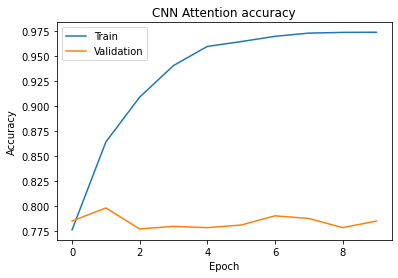

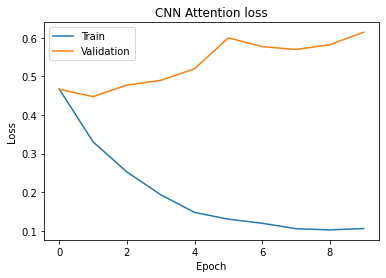

In [ ]:
# Plotar métricas
plot_graphs(att_history, "CNN Attention")